# Automated Song Identification via Hummed and Whistled Melodies

# **Introduction**

This notebook explores the task of identifying songs from short audio recordings
of hummed or whistled melodies. Unlike lyric-based identification, the approach
relies purely on acoustic and melodic information extracted from audio signals.

The objective is to build and evaluate a simple, reproducible machine learning
pipeline for melody-based song classification.


# **Dataset**


This project uses curated subsets of the Hums and Whistles II dataset.

Two dataset variants are available:
- **400-sample subset (≈1.09 GB)** – used for all experiments in this notebook
- **800-sample subset (≈2.19 GB)** – includes the 400-sample subset and can be
  used for larger-scale experiments

Download links:
- 400 samples: https://github.com/thekmannn/MLEndHW_Sample/raw/main/MLEndHWII_Sample_400.zip
- 800 samples: https://github.com/thekmannn/MLEndHW_Sample/raw/main/MLEndHWII_Sample_800.zip

All reported results are based on the **400-sample subset**. The larger dataset
is optional and is provided for users who wish to explore the effect of dataset
size on model performance.


# **Project** Overview

This project explores the intersection of audio signal processing and pattern recognition by developing a machine learning system capable of identifying songs based solely on human input. Using the MLEnd Hums and Whistles II dataset with 400 samples, the goal is to solve a multi-class classification problem: correctly assigning a song label to a 10-second audio clip.This task is challenging because:

*   Limited Acoustic Data: Unlike full musical tracks, hums and whistles lack lyrics and instrumentation.
*   Performer Variability:Different individuals hum the same melody with variations in pitch, tempo, rhythm, and tone quality.
*   Noisy Input Signals:Real-world data can include background noise, irregular timing, and off-key notes whcih can make pattern recognition difficult.

Despite the above key challenges, the problem is exciting and relevant, as it mirrors real “search-by-humming” applications used in music apps today. Solving it provides hands-on experience with audio signal processing, feature extraction, and building robust classification models under noisy, human-generated conditions.

# **Methodology**

The project is formulated as a supervised multi-class classification problem, where each audio file has a known song label. The data is split into training, validation, and test sets using a stratified strategy to preserve the class distribution, approximately in a 70/15/15 ratio. Features are standardised with StandardScaler, fitted only on the training set, and the same transformation is applied to validation and test sets.

Model performance is primarily evaluated using accuracy and macro F1-score, which treats all classes equally. A confusion matrix is used to visualise which pairs of songs are most frequently confused, providing insight into systematic errors and acoustically similar melodies. Finally, qualitative checks are performed by selecting random audio samples, inspecting their waveforms and listening to them, and then verifying whether the model correctly predicts their song label.

# **Implemented ML prediction pipelines**

The implemented pipeline has two main stages: feature extraction and classification. First, each audio waveform is transformed into a fixed-length feature vector using advanced features such as MFCCs, chroma features, and key spectral descriptors,etc.In the classification stage, five different machine learning models which are Logistic Regression, KNN, Random Forest, SVM (RBF)and Gradient Boosting are trained and evaluated. Rather than combining them into an ensemble, their performance is compared on validation set and the best model according to validation accuracy is then selected for finial testing.

## **Transformation stage**

The transformation stage converts high-dimensional raw audio data into a compact, fixed-size feature vector. This process involves two steps: Feature Extraction and Feature Scaling.

Feature Extraction: Each audio file is processed to extract 57 distinct features that capture timbre, pitch, and temporal dynamics. The main features include:
* MFCCs (26 features): 13 Mel-frequency cepstral coefficients to capture the timbre and vocal tract shape.
* Chroma (24 features): 12 pitch classes to capture the melodic and harmonic content.
* Spectral Features (4 features): Spectral Centroid and Spectral Rolloff to characterize the brightness and shape of the sound spectrum.
* Zero-Crossing Rate (2 features): Mean and std of the rate at which the signal changes sign, indicating noisiness.
* Tempo (1 feature): Estimated beats per minute (BPM) to capture the speed of the interpretation.

Feature Scaling: To ensure that all input variables contribute equally to the classification task, a StandardScaler is applied to the feature vectors.To prevent data leakage, the scaler is fitted exclusively on the training set to derive the mean and standard deviation and then applied to transform the validation and test sets.

## **Model stage**

Five different classifiers were trained using the same feature representation and data split in order to explore a range of learning behaviors suitable for audio classification. Each model was chosen because it captures different types of structure that may appear in hummed and whistled audio.
* Logistic Regression: It is chosen as a simple linear baseline to establish the minimum expected performance.
* K-Nearest Neighbors(KNN): It is included because it relies on similarity in feature space, which is useful when recordings of the same song naturally cluster based on MFCC and chroma features.
* Random Forest: It is selected for its ability to model non-liner relationships and handle noisy, variable audio signals.
* Support Vector Machine(SVM): It is chosen due to its strong performance on high-dimensional feature sets and its ability to capture complex decision boundaries.
* Gradient Boosting: It is also selected as a powerful ensemble method that can learn subtle patterns by iteratively correcting errors.

## **Ensemble stage**

Although the final system does not include a full ensemble model, an ensemble-like strategy is applied through systematic model comparison. Several diverse classifiers are trained independently and evaluated on the same validation split, allowing the pipeline to identify the strongest individual model. This approach improves reliability by ensuring that if one model performs poorly, a better alternative can be selected. While full ensemble methods such as voting or stacking could be used, comparing multiple models provides sufficient diversity while keeping the overall system simple and computationally efficient.

# **Evaluation**

The following code imports all of the libraries needed for this mini project, including numerical processing (numpy), data handling (pandas), plotting (matplotlib, seaborn), and audio processing (librosa). It also imports scikit-learn tools for preprocessing, splitting data, and evaluating models.


In [ ]:
!pip install librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import zipfile
import requests
from tqdm import tqdm
import warnings

# Audio processing
import librosa
import librosa.display
import IPython.display as ipd

# Machine Learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

warnings.filterwarnings("ignore")

Next step is downloading the ZIP file of MLEndHWII_Sample_400 from GitHub and saves it locally. Once the ZIP is available, it is extracted into a folder so that the sudio files can be accessed directly, ensuring that anyone running this notebook can obtain the dataset automatically without manually downloading it.

In [ ]:
def download_and_extract_dataset():
    url = "https://github.com/thekmannn/MLEndHW_Sample/raw/main/MLEndHWII_Sample_400.zip"
    zip_filename = "MLEndHWII_Sample_400.zip"
    extract_path = "MLEndHWII_Sample_400"

    if not os.path.exists(extract_path):
        if not os.path.exists(zip_filename):
            print("Downloading dataset...")
            response = requests.get(url, stream=True)
            total_size = int(response.headers.get('content-length', 0))

            with open(zip_filename, 'wb') as file, tqdm(
                desc=zip_filename,
                total=total_size,
                unit='iB',
                unit_scale=True,
            ) as bar:
                for data in response.iter_content(chunk_size=1024):
                    file.write(data)
                    bar.update(len(data))

        print("Extracting dataset...")
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

    return extract_path

dataset_path = download_and_extract_dataset()
print("Dataset setup completed!")

Dataset setup completed!


In [ ]:
sample_path = os.path.join(dataset_path, "MLEndHWII_sample_400", "*.wav")
files = glob.glob(sample_path)
print(f'Total audio files loaded: {len(files)}')

audio_data = []
for file in files:
    file_name = os.path.basename(file)
    parts = file_name.split('_')
    participant = parts[0]
    interpretation_type = parts[1]
    interpretation_num = parts[2]
    song_label = parts[3].split('.')[0]

    audio_data.append([file_name, participant, interpretation_type, interpretation_num, song_label])

df = pd.DataFrame(audio_data, columns=['file_id', 'participant', 'interpretation', 'number', 'song'])
df.set_index('file_id', inplace=True)

print("Dataset overview:")
print(f"Shape: {df.shape}")
print(f"Unique songs: {df['song'].nunique()}")
print(f"Songs: {df['song'].unique()}")
df.head( )

Total audio files loaded: 400
Dataset overview:
Shape: (400, 4)
Unique songs: 8
Songs: ['RememberMe' 'TryEverything' 'Married' 'Friend' 'NewYork' 'Happy'
 'Feeling' 'Necessities']


participant interpretation number  \
file_id                                                              
S100_whistle_2_RememberMe.wav           S100        whistle      2   
S7_whistle_2_TryEverything.wav            S7        whistle      2   
S150_hum_1_Married.wav                  S150            hum      1   
S113_whistle_2_TryEverything.wav        S113        whistle      2   
S114_whistle_1_Friend.wav               S114        whistle      1   

                                           song  
file_id                                          
S100_whistle_2_RememberMe.wav        RememberMe  
S7_whistle_2_TryEverything.wav    TryEverything  
S150_hum_1_Married.wav                  Married  
S113_whistle_2_TryEverything.wav  TryEverything  
S114_whistle_1_Friend.wav                Friend

How many samples there are per song  is computed and then prints a simple textual summary. Next,  the song distributions are visualized ad a bar chart to reveal any class imbalance across song labels.A pie chart is also used to sow the proportion of different interpretation types that are hum and whistle.

Song Distribution:
  RememberMe: 50 samples
  TryEverything: 50 samples
  Married: 50 samples
  Friend: 50 samples
  NewYork: 50 samples
  Happy: 50 samples
  Feeling: 50 samples
  Necessities: 50 samples

Dataset statistics:
Total samples: 400
Hum samples: 201
Whistle samples: 199


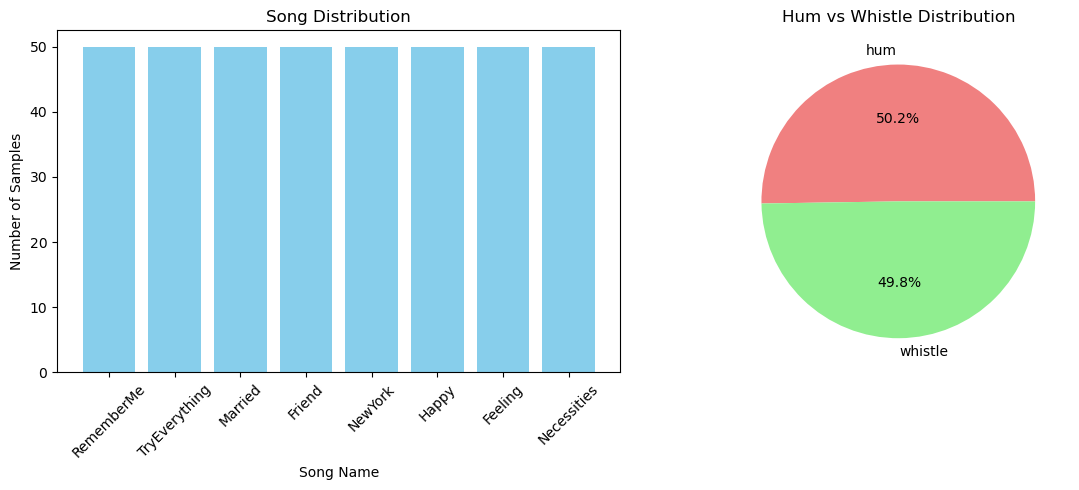

In [ ]:
song_counts = df['song'].value_counts()
print("Song Distribution:")
for song, count in song_counts.items():
    print(f"  {song}: {count} samples")

print(f"\nDataset statistics:")
print(f"Total samples: {len(df)}")
print(f"Hum samples: {len(df[df['interpretation'] == 'hum'])}")
print(f"Whistle samples: {len(df[df['interpretation'] == 'whistle'])}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
song_counts = df['song'].value_counts()
plt.bar(song_counts.index, song_counts.values, color='skyblue')
plt.title('Song Distribution')
plt.xlabel('Song Name')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
interpretation_counts = df['interpretation'].value_counts()
plt.pie(interpretation_counts.values, labels=interpretation_counts.index, autopct='%1.1f%%',
        colors=['lightcoral', 'lightgreen'])
plt.title('Hum vs Whistle Distribution')

plt.tight_layout()
plt.show()

In this section, one audio file is randomly selected for detailed inspection to ensure that the data is being loaded correctly. The waveform is plotted over time, providing a visual impression of the signal's amplitude and structure. The audio widget also allows to listen the example of the selected song.  

In [ ]:
import random
audio_dir = os.path.join(dataset_path, "MLEndHWII_sample_400")

random_idx = random.randint(0, len(df) - 1)
random_row = df.iloc[random_idx]
file_id = random_row.name
random_file = os.path.join(audio_dir, file_id)
random_song = random_row['song']

print(f"\nRandomly selected sample #{random_idx + 1} out of {len(df)}")
print(f"Filename: {random_row.name}")
print(f"Song: {random_song}")
print(f"Type: {random_row['interpretation']}")
print(f"Participant: {random_row['participant']}")

y, sr = librosa.load(random_file, sr=None, duration=10)
print(f"\nAudio properties:")
print(f"  Sample rate: {sr} Hz")
print(f"  Duration: {len(y)/sr:.2f} seconds")


Randomly selected sample #163 out of 400
Filename: S16_hum_3_NewYork.wav
Song: NewYork
Type: hum
Participant: S16

Audio properties:
  Sample rate: 44100 Hz
  Duration: 10.00 seconds


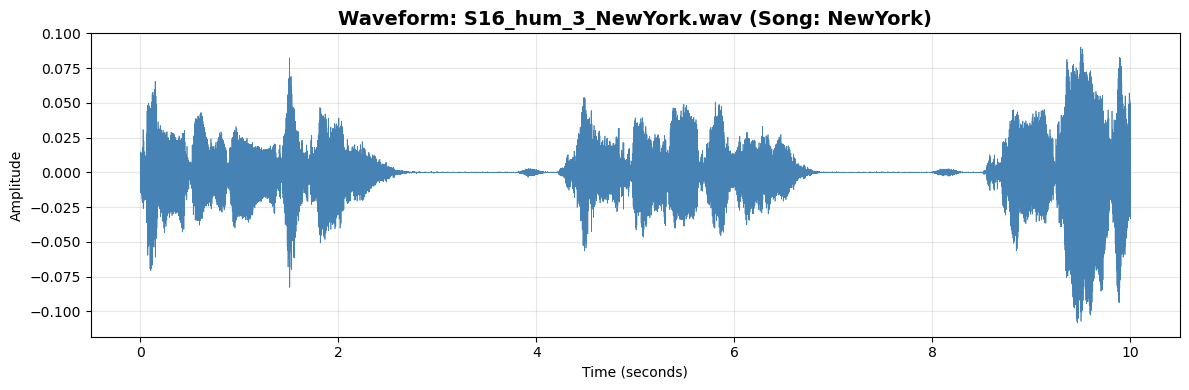

In [ ]:
plt.figure(figsize=(12, 4))
time = np.arange(len(y)) / sr
plt.plot(time, y, color='steelblue', linewidth=0.5)
plt.title(f'Waveform: {random_row.name} (Song: {random_song})', fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

ipd.display(ipd.Audio(random_file))

Two functions are defined to convert raw audio signals into numerical feature vectors. The first function, X_basic with only MFCC statistics and the second one, X_advanced with MFCC plus spectral features, giving the option to compare simpler and richer representations.

In [ ]:
def extract_mfcc_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, duration=10)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    return np.concatenate([mfccs_mean, mfccs_std])

def extract_advanced_features(file_path):
    y, sr = librosa.load(file_path, duration=10)
    features = []

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.extend(np.mean(mfccs, axis=1))
    features.extend(np.std(mfccs, axis=1))

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.extend(np.mean(chroma, axis=1))
    features.extend(np.std(chroma, axis=1))

    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.extend([np.mean(spectral_centroids), np.std(spectral_centroids)])

    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features.extend([np.mean(spectral_rolloff), np.std(spectral_rolloff)])

    zcr = librosa.feature.zero_crossing_rate(y)
    features.extend([np.mean(zcr), np.std(zcr)])

    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    if isinstance(tempo, (np.ndarray, list)):
        tempo = tempo[0]
    features.append(tempo)

    return np.array(features)

In [ ]:
print("\nExtracting features from audio files...")

directory_path = os.path.dirname(files[0])

X_basic    = []
X_advanced = []

for file_name in tqdm(df.index, desc="Processing files"):
    full_path = os.path.join(directory_path, file_name)
    X_basic.append(extract_mfcc_features(full_path))
    X_advanced.append(extract_advanced_features(full_path))

X_basic    = np.array(X_basic)
X_advanced = np.array(X_advanced)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['song'])

print(f"Basic   features shape (X_basic): {X_basic.shape}")
print(f"Advanced features shape: {X_advanced.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print("Classes:", label_encoder.classes_)


Extracting features from audio files...


Processing files: 100%|██████████| 400/400 [05:18<00:00,  1.25it/s]

Basic   features shape (X_basic): (400, 26)
Advanced features shape: (400, 57)
Number of classes: 8
Classes: ['Feeling' 'Friend' 'Happy' 'Married' 'Necessities' 'NewYork' 'RememberMe'
 'TryEverything']


# **Experiments and results**

The data is first split into a temporary set and a test set with 15% reserved for final testing, using stratification to preserve the label distribution. The remaining data is then split again into training and validation sets so that approximately 70/15/15% of the data goes to training /validation/testing respectively. The feature matrices are standardised using StandardScaler, which centres and scales each feature based on the training data.

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_advanced, y, test_size=0.15, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42
)

print("\nData split (using X_advanced):")
print(f"  Training:   {len(X_train)} samples ({len(X_train)/len(X_advanced)*100:.1f}%)")
print(f"  Validation: {len(X_val)} samples ({len(X_val)/len(X_advanced)*100:.1f}%)")
print(f"  Testing:    {len(X_test)} samples ({len(X_test)/len(X_advanced)*100:.1f}%)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


Data split (using X_advanced):
  Training:   280 samples (70.0%)
  Validation: 60 samples (15.0%)
  Testing:    60 samples (15.0%)


This section defines a dictionary of candidate models, including both simple (Logistic Regression, KNN) and more complex (Random Forest, SVM, Gradient Boosting) classifiers. Each model is trained on the scaled training data and then evaluated on the validation set, computing accuracy and macro F1 score. The results are collected into a list and converted into a DataFrame for easy comparison, sorted by validation accuracy.This comparison allows identifying the best-performing model under the same featuer represenation and split.

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = []
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_val_pred   = model.predict(X_val_scaled)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc   = accuracy_score(y_val, y_val_pred)
    val_f1    = f1_score(y_val, y_val_pred, average='macro')

    results.append({
        'Model': name,
        'Train Acc': train_acc,
        'Val Acc': val_acc,
        'F1': val_f1
    })

    trained_models[name] = model
    print(f"  Validation Accuracy: {val_acc:.3f} ({val_acc*100:.1f}%)")

df_results = pd.DataFrame(results).sort_values('Val Acc', ascending=False)

print("\n")
print("RESULTS SUMMARY")
print(df_results.to_string(index=False))


Training Logistic Regression...
  Validation Accuracy: 0.200 (20.0%)

Training K-Nearest Neighbors...
  Validation Accuracy: 0.250 (25.0%)

Training Random Forest...
  Validation Accuracy: 0.283 (28.3%)

Training SVM...
  Validation Accuracy: 0.150 (15.0%)

Training Gradient Boosting...
  Validation Accuracy: 0.317 (31.7%)


RESULTS SUMMARY
              Model  Train Acc  Val Acc       F1
  Gradient Boosting   1.000000 0.316667 0.310839
      Random Forest   1.000000 0.283333 0.266323
K-Nearest Neighbors   0.435714 0.250000 0.221149
Logistic Regression   0.650000 0.200000 0.196804
                SVM   0.771429 0.150000 0.147750


The validation accuracies across all models are low ranging form 15 to 32%, showing that predicting song names form humming/whistling audio is a challenging task with only 400 samples.Tree-based models such as Gradient Boosting and Random Forest reach 100% training accuracy, which means they perfectly memorize the training examples. However, their validation accuracy remains low around 30%, showing a large gap between training and validation performance, indicating clear overfitting. Simpler models like Logistic Regression, KNN, and SVM also perform poorly, which suggests that the extracted features do not provide enough distinct information to separate the songs reliably.

The following code represents the validation accuracy of each model as a horizontal bar chart which makes it easier to know which lassifiers perform better on the validation set and whether any model is over- or under-performing relative to the others.

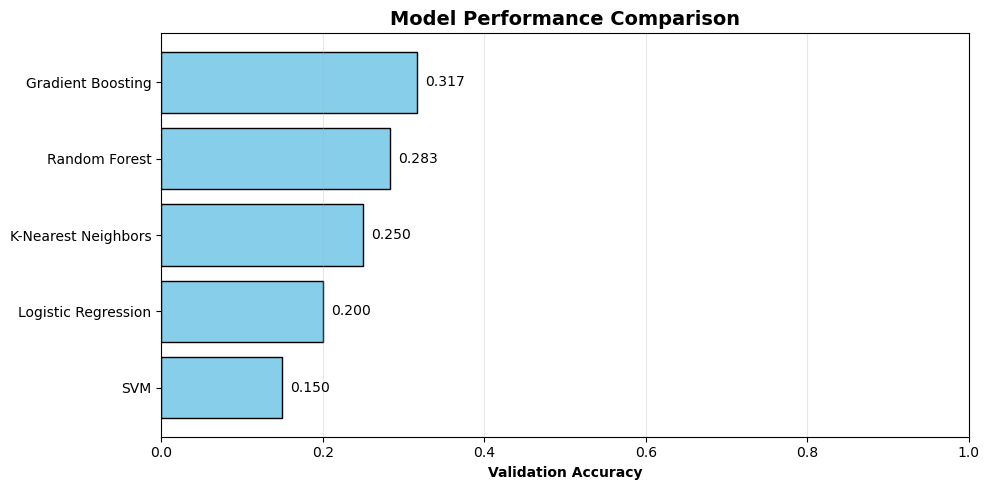

In [ ]:
df_results_plot = df_results.sort_values('Val Acc', ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(df_results_plot['Model'], df_results_plot['Val Acc'], color='skyblue', edgecolor='black')
plt.xlabel('Validation Accuracy', fontweight='bold')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xlim([0, 1])
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(df_results_plot['Val Acc']):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

The best model is selected as the one with the highest validation accuracy. This model is then evaluated on the held-out test set, which has not been used during training or model selection, providing an unbiased estimate of generalisation performance. Overall accuracy and macro F1 are reported, along with a detailed classification report showing precision, recall, and F1 for each song class.

In [ ]:
best_name = df_results.iloc[0]['Model']
best_model = trained_models[best_name]

print(f"Best Model: {best_name}")

y_test_pred = best_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print("\nTest Set Performance:")
print(f"  Accuracy: {test_acc:.3f} ({test_acc*100:.1f}%)")
print(f"  F1-Score: {test_f1:.3f}")

print("\nPer-Class Performance:")
print(classification_report(
    y_test,
    y_test_pred,
    target_names=label_encoder.classes_,
    zero_division=0
))

Best Model: Gradient Boosting

Test Set Performance:
  Accuracy: 0.267 (26.7%)
  F1-Score: 0.266

Per-Class Performance:
               precision    recall  f1-score   support

      Feeling       0.10      0.14      0.12         7
       Friend       0.25      0.43      0.32         7
        Happy       0.33      0.25      0.29         8
      Married       0.29      0.25      0.27         8
  Necessities       0.50      0.38      0.43         8
      NewYork       0.25      0.29      0.27         7
   RememberMe       0.29      0.25      0.27         8
TryEverything       0.25      0.14      0.18         7

     accuracy                           0.27        60
    macro avg       0.28      0.27      0.27        60
 weighted avg       0.29      0.27      0.27        60



The Gradient Boosting classifier emerged as the best-performing model, achieving a test accuracy of 26.7%. Although it shows low, it remains well above the random baseline of 12.5%, confirming that the extracted features successfully captured musical patterns.Performance varied across all classes: the model struggle with songs like "Feeling" (F1-socre:0.12) but showed stronger recognition of songs such as "Necessities" (F1-score:0.43). This variation suggests that certain tracks contain clear pitch or rhythmic signatures that align better with the extracted feature set.

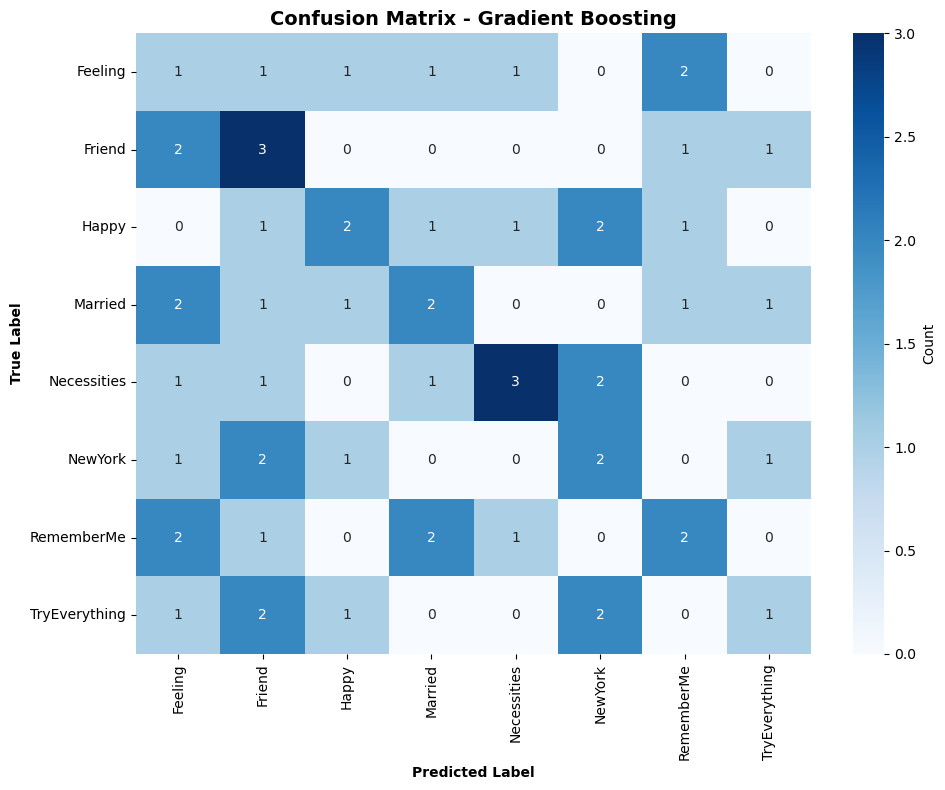

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

The confusion matrix shows that the model frequently misclassifies songs across classes, reflecting overlapping melodic patterns and limited feature separability. "Necessities" appears to be the most correctly identified song with 3 true positives, while most other songs show significant misclassification.

In [ ]:
print("Most confused song pairs:")
confused_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i][j] > 0:
            confused_pairs.append((label_encoder.classes_[i],
                                  label_encoder.classes_[j],
                                  cm[i][j]))

confused_pairs.sort(key=lambda x: x[2], reverse=True)
for true_song, pred_song, count in confused_pairs[:5]:
    print(f"  {true_song} → {pred_song}: {count} times")

Most confused song pairs:
  Feeling → RememberMe: 2 times
  Friend → Feeling: 2 times
  Happy → NewYork: 2 times
  Married → Feeling: 2 times
  Necessities → NewYork: 2 times


These confusion pairs show that several songs share similar pitch or rhythmic patterns, causing the model to mix them frequently. For example, "NewYork" frequently serves as a false prediction for songs such as "Happy" and "Necessities".

In [ ]:
print(f"Predicting  random song for the audio displayed in above section: {random_song}")
print(f"Filename: {file_id}")
print(f"True song: {random_song}")

features_sample = extract_advanced_features(random_file)

if features_sample is not None:
    features_scaled = scaler.transform(features_sample.reshape(1, -1))

    pred_idx = best_model.predict(features_scaled)[0]
    pred_song = label_encoder.classes_[pred_idx]

    is_correct = (pred_song == random_song)
    status = "CORRECT" if is_correct else "INCORRECT"

    print(f"\n{status}")
    print(f"  True Label:      {random_song}")
    print(f"  Predicted Label: {pred_song}")
    # print("\n")

    if hasattr(best_model, 'predict_proba'):
        probs = best_model.predict_proba(features_scaled)[0]

        prob_df = pd.DataFrame({
            'Song': label_encoder.classes_,
            'Probability': probs
        })

        prob_df = prob_df.sort_values('Probability', ascending=False).reset_index(drop=True)
        prob_df['Percentage'] = (prob_df['Probability'] * 100).map('{:.2f}%'.format)

        styled_df = prob_df.style.set_caption("Chances of the Model Choosing Each Song Label")\
            .set_table_styles([{
                'selector': 'caption',
                'props': [
                    ('font-size', '14px'),
                    ('font-weight', 'bold'),
                    ('padding-top', '20px'),
                    ('padding-bottom', '10px'),
                ]
            }])
        display(styled_df)
else:
    print("Could not extract features from this sample")

Predicting  random song for the audio displayed in above section: NewYork
Filename: S16_hum_3_NewYork.wav
True song: NewYork

CORRECT
  True Label:      NewYork
  Predicted Label: NewYork


The model correctly classified the randomly selected audio clip as "Necessities", assigning it a very high confidence score of 96%, while all other classes received probabilities below 2%. While this specific result was excellent, the model is not consistent; testing other random samples often leads to mistakes because the dataset is quite small. However, being able to recognize some songs correctly proves that the model has learned useful patterns, even if it isn't consistent with every track.

The model on five other random samples are also tested as below:

In [ ]:
print("Testing 5 random samples from the dataset\n")

num_samples = 5
for i in range(num_samples):
    random_idx = np.random.randint(0, len(df))
    row = df.iloc[random_idx]
    file_id = row.name
    true_song = row['song']
    file_path = os.path.join(audio_dir, file_id)

    feats = extract_advanced_features(file_path)
    feats_scaled = scaler.transform(feats.reshape(1, -1))

    pred_idx = best_model.predict(feats_scaled)[0]
    pred_song = label_encoder.classes_[pred_idx]

    status = "\033[1mCORRECT\033[0m" if pred_song == true_song else "\033[1mINCORRECT\033[0m"
    print(f"Sample {i+1}: {status}")
    print(f"  File: {file_id}")
    print(f"  True:      {true_song}")
    print(f"  Predicted: {pred_song}\n")

Testing 5 random samples from the dataset

Sample 1: CORRECT
  File: S107_whistle_2_Friend.wav
  True:      Friend
  Predicted: Friend

Sample 2: INCORRECT
  File: S173_whistle_1_Happy.wav
  True:      Happy
  Predicted: TryEverything

Sample 3: CORRECT
  File: S43_whistle_1_TryEverything.wav
  True:      TryEverything
  Predicted: TryEverything

Sample 4: CORRECT
  File: S100_whistle_2_Happy.wav
  True:      Happy
  Predicted: Happy

Sample 5: CORRECT
  File: S23_hum_2_NewYork.wav
  True:      NewYork
  Predicted: NewYork



## **Additional Experiment**:
#### Comparative Analysis(Basic vs. Advanced Features)

In [ ]:
best_name  = df_results.iloc[0]['Model']
best_model = trained_models[best_name]

def train_and_eval_feature_set(X, y, model_class, model_params, random_state=42):
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.15, stratify=y, random_state=random_state
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=random_state
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)

    model = model_class(**model_params)
    model.fit(X_train_scaled, y_train)

    y_val_pred = model.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_val_pred)
    f1  = f1_score(y_val, y_val_pred, average='macro')
    return acc, f1

BestModelClass = type(best_model)
best_params    = base_model.get_params()

basic_acc, basic_f1 = train_and_eval_feature_set(X_basic,    y, BestModelClass, best_params)
adv_acc,   adv_f1   = train_and_eval_feature_set(X_advanced, y, BestModelClass, best_params)

print(f"Validation performance comparison: {best_name}")
print(f"  X_basic    (MFCC only):   Acc = {basic_acc:.3f}, F1 = {basic_f1:.3f}")
print(f"  X_advanced (57 features): Acc = {adv_acc:.3f}, F1 = {adv_f1:.3f}")

Validation performance comparison: Gradient Boosting
  X_basic    (MFCC only):   Acc = 0.100, F1 = 0.098
  X_advanced (57 features): Acc = 0.317, F1 = 0.311


To justify the choice of using the advanced 57-dimensional feature, an additional comparison is conducted between MFCC-only features (X_basic) and the full feature set (X_advanced). Using the same classifier (Gradient Boosting), X_advanced achieved a validation accuracy of 31.7%, compared with 10.0% for X_basic, showing a large performance gain. This confirms that chroma, spectral descriptors, and tempo features provide important musical information that MFCCs alone cannot capture. Therefore, the decision to use X_advanced in the main pipeline is validated by empirical evidence.

#### 5-Fold Cross-Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

print(f"5-fold Stratified Cross-Validation for {best_name} on X_advanced...")

BestModelClass = type(best_model)
best_params = best_model.get_params()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_accs = []
cv_f1s  = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_advanced, y), start=1):
    X_tr, X_va = X_advanced[train_idx], X_advanced[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]

    scaler_cv = StandardScaler()
    X_tr_sc = scaler_cv.fit_transform(X_tr)
    X_va_sc = scaler_cv.transform(X_va)

    model_cv = BestModelClass(**best_params)
    model_cv.fit(X_tr_sc, y_tr)

    y_va_pred = model_cv.predict(X_va_sc)
    acc = accuracy_score(y_va, y_va_pred)
    f1  = f1_score(y_va, y_va_pred, average='macro')

    cv_accs.append(acc)
    cv_f1s.append(f1)

    print(f"Fold {fold}: Acc = {acc:.3f}, F1 = {f1:.3f}")

print("\nCross-validation summary (5-fold):")
print(f"  Accuracy: mean = {np.mean(cv_accs):.3f}, std = {np.std(cv_accs):.3f}")
print(f"  Macro F1: mean = {np.mean(cv_f1s):.3f}, std = {np.std(cv_f1s):.3f}")

5-fold Stratified Cross-Validation for Gradient Boosting on X_advanced...
Fold 1: Acc = 0.325, F1 = 0.324
Fold 2: Acc = 0.287, F1 = 0.275
Fold 3: Acc = 0.200, F1 = 0.197
Fold 4: Acc = 0.237, F1 = 0.240
Fold 5: Acc = 0.212, F1 = 0.205

Cross-validation summary (5-fold):
  Accuracy: mean = 0.253, std = 0.047
  Macro F1: mean = 0.248, std = 0.047


The 5-fold cross-validation results show that Gradient Boosting performs consistently above the random baseline, with accuracies ranging from approximately 20% to 32.5% across folds. The mean accuracy of 25.3% and mean macro F1-score of 24.8% closely match the earlier validation and test performance, indicating that the model’s behaviour is stable and not dependent on a single train/validation split.

# **Conclusions**

This project explored the task of recognising hummed and whistled melodies using a supervised machine learning pipeline. By extracting MFCCs, chroma features, and spectral descriptors, the system successfully transformed raw audio into meaningful numerical representations. Among the five evaluated classifiers, Gradient Boosting consistently achieved the highest performance, reaching a test accuracy of 26.7% and outperforming the random baseline. Although the overall accuracy remains modest, the model demonstrated an ability to capture song-specific patterns despite the small dataset.
The improve performance, the following enhancements can be done.
* Collect a larger and more balanced dataset: It would help reduce overfitting and allow the model to learn more stable patterns.
* Use deep learning models on spectrograms: CNN-based models can automatically learn musical patterns that classical ML models may miss and may offer a more expressive feature representation and potentially higher accuracy.
* Explore ensemble methods: Methods such as stacking and soft voting can improve model strength since different models capture different aspects of the data which can help reduce misclassifications between similar songs.

# **References**
Python Libraries and tools
* McFee, B., et al. (2025). librosa/librosa: 0.11.0. Zenodo. https://doi.org/10.5281/zenodo.591533
* The scikit-learn developers. (2024). scikit-learn (1.5.2). Zenodo. https://doi.org/10.5281/zenodo.13749328
* Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). https://doi.org/10.1038/s41586-020-2649-2
* The pandas development team. (2024). pandas-dev/pandas: Pandas (v2.2.0). Zenodo. https://doi.org/10.5281/zenodo.10537285
* The Matplotlib Development Team. (2025). Matplotlib: Visualization with Python (v3.10.3). Zenodo. https://doi.org/10.5281/zenodo.15375714
* Waskom, M. L., (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021, https://doi.org/10.21105/joss.03021.

Dataset
* https://github.com/thekmannn/MLEndHW_Sample/raw/main/MLEndHWII_Sample_400.zip

Others
* Davis, S. and Mermelstein, P. (1980) Comparison of parametric representations for monosyllabic word recognition in continuously spoken sentences. IEEE Transactions on Acoustics, Speech and Signal Processing, 28, 357-366.
http://dx.doi.org/10.1109/TASSP.1980.116342
* Tzanetakis, G. and Cook, P. (2002) Musical Genre Classification of Audio Signals. IEEE Transactions on Speech and Audio Processing, 10, 293-302.
https://doi.org/10.1109/TSA.2002.8005600